In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import DMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

Dataset Info

In [8]:
data = pd.read_csv('payment-practicesold.csv')

In [9]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [10]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [11]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().sum()/77681)*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10381,13.363628
Average time to pay,2448,3.151350
% Invoices paid within 30 days,2448,3.151350
% Invoices paid between 31 and 60 days,2448,3.151350
% Invoices paid later than 60 days,2448,3.151350
% Invoices not paid within agreed terms,2405,3.095995
Shortest (or only) standard payment period,2405,3.095995
Longest standard payment period,9919,12.768888
Maximum contractual payment period,2405,3.095995
Payment terms have changed,2405,3.095995


In [12]:
data = data.dropna(subset=['E-Invoicing offered'])

In [25]:
data['Payments made in the reporting period'] = data['Payments made in the reporting period'].fillna(0)

In [26]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed


In [28]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [29]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X = std.fit_transform(data[['Average time to pay']])

80th Quantile =  51.0


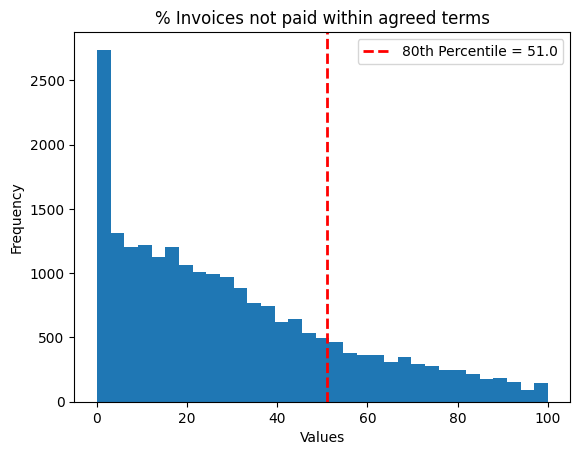

In [30]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [31]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

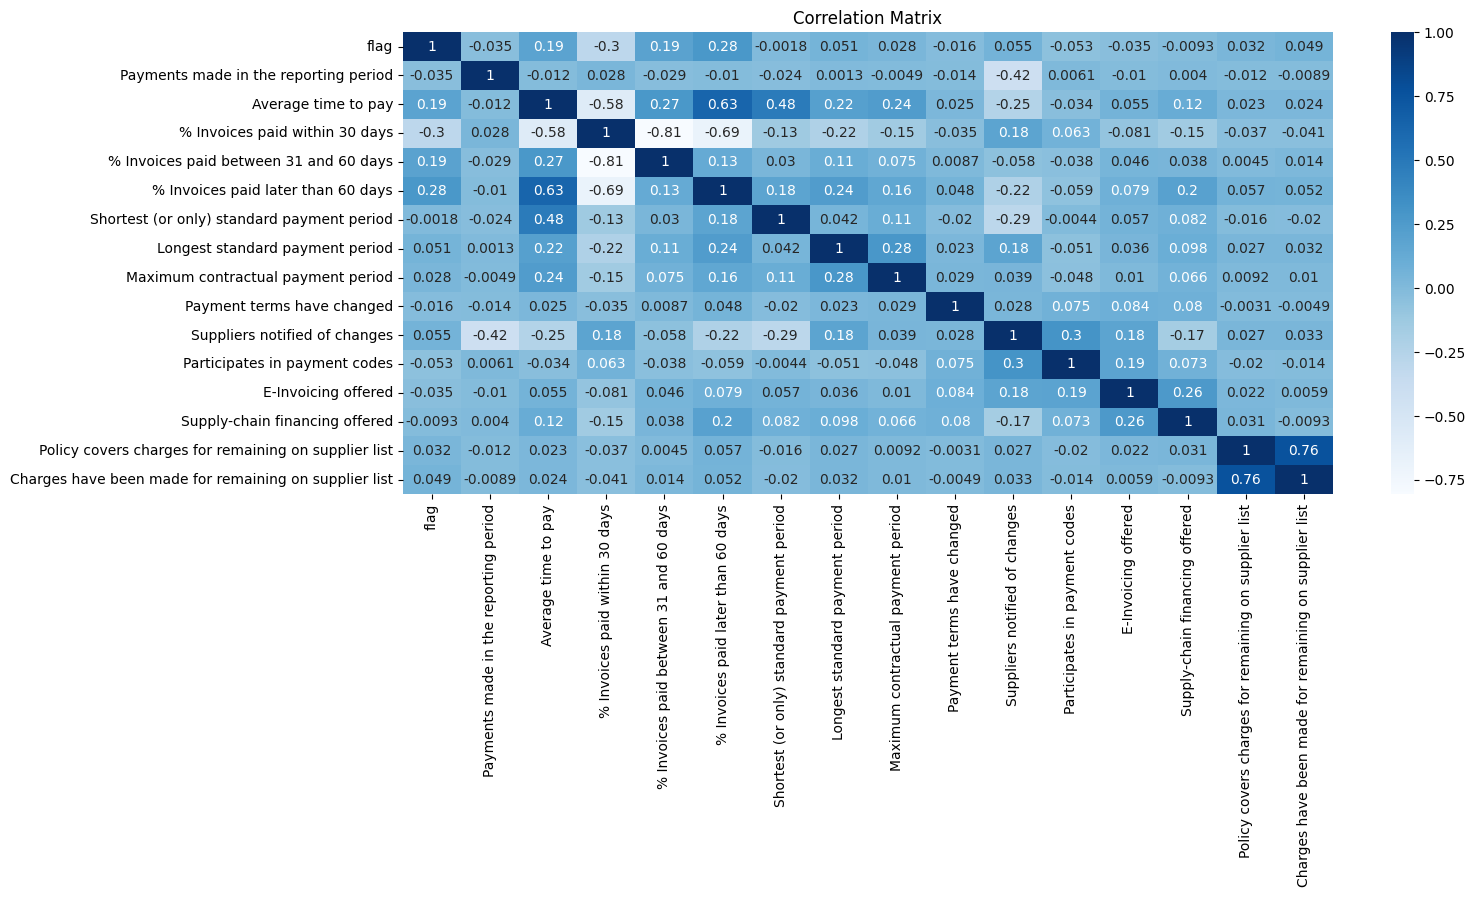

In [32]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

In [36]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list',])

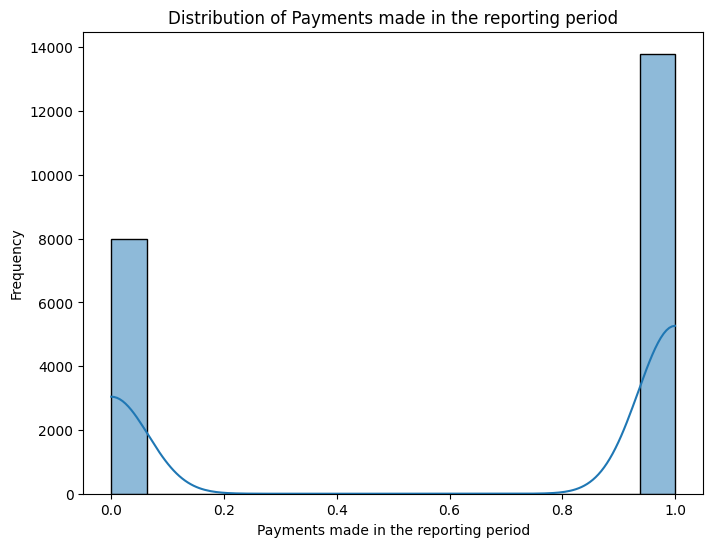

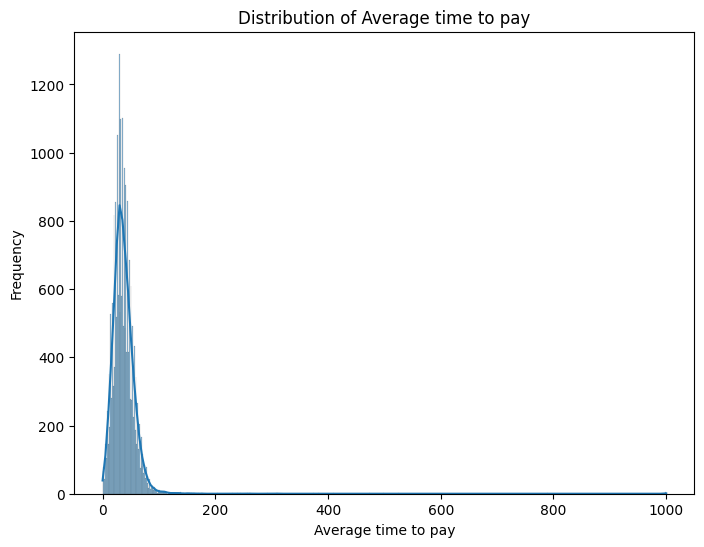

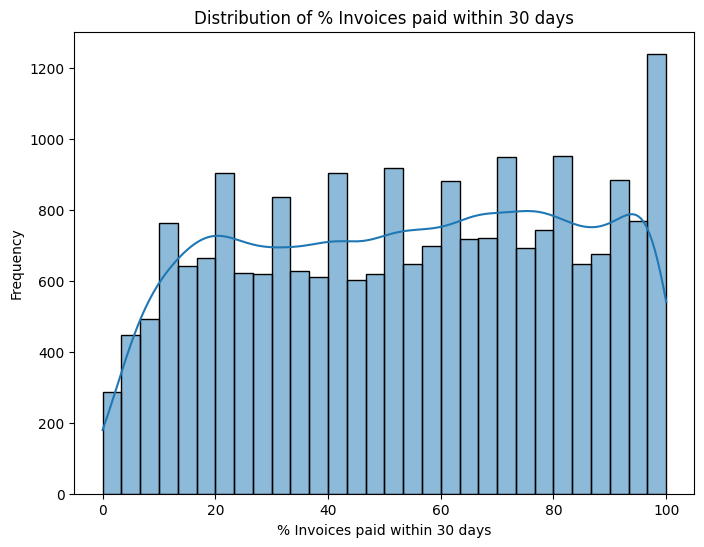

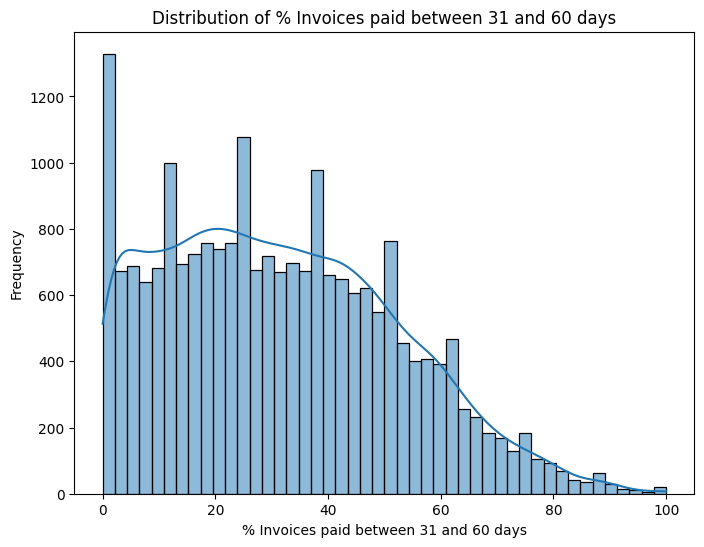

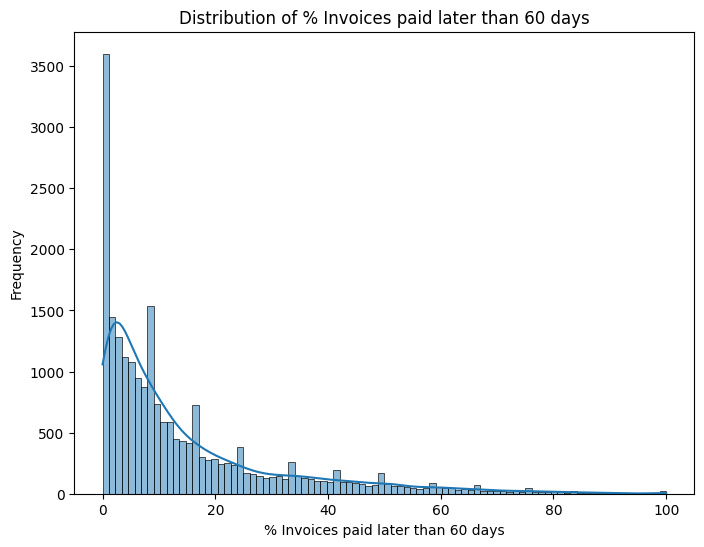

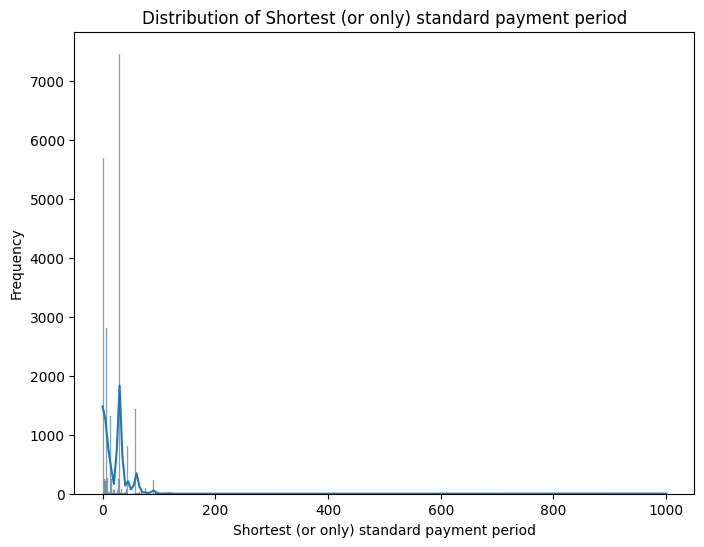

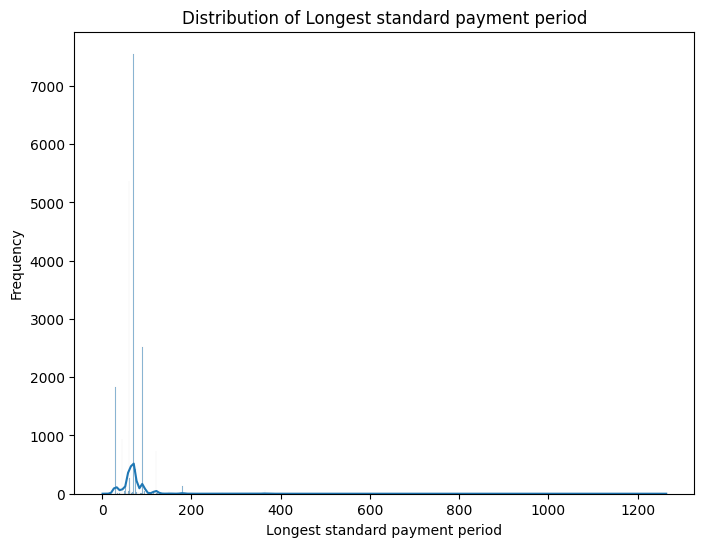

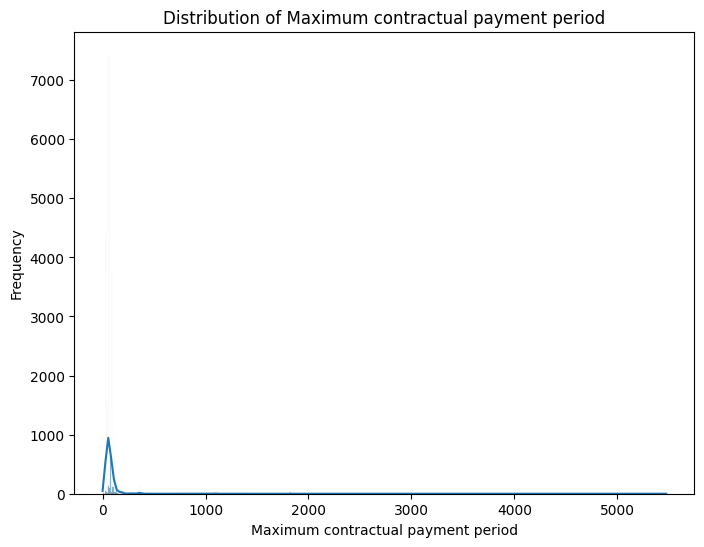

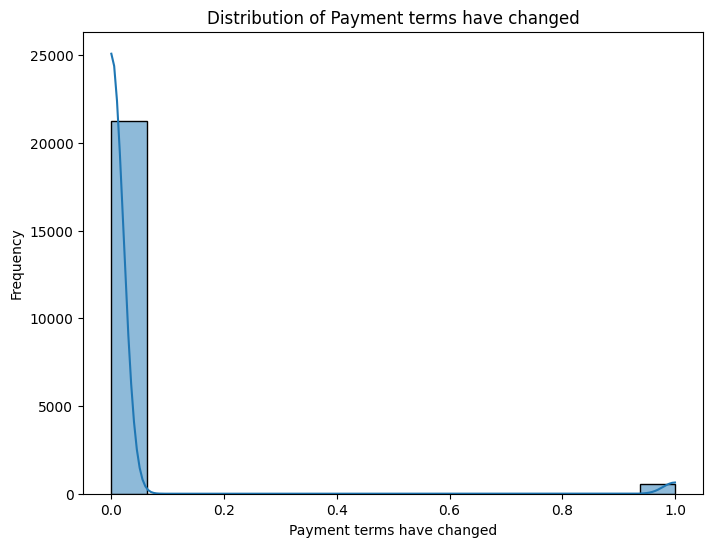

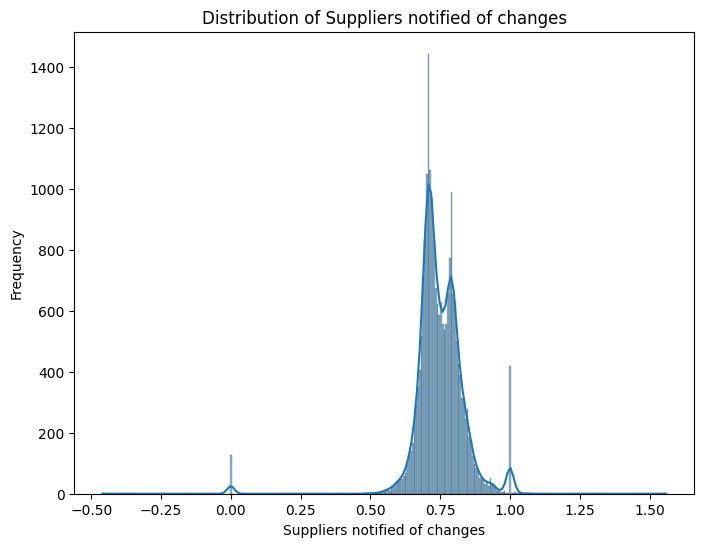

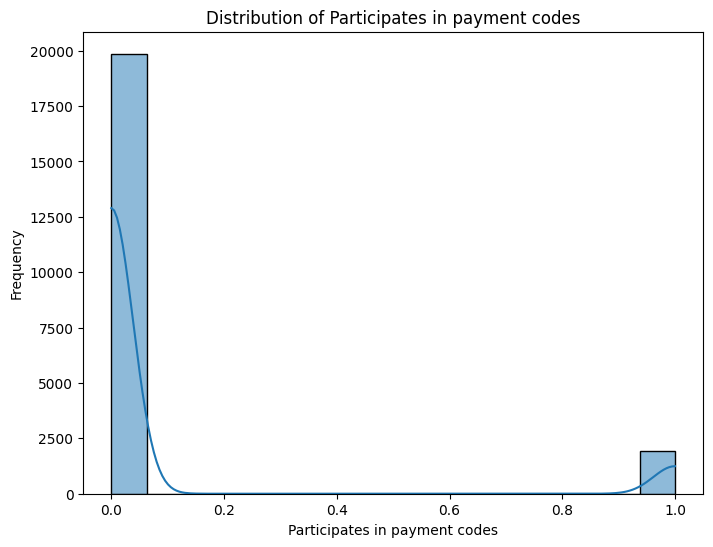

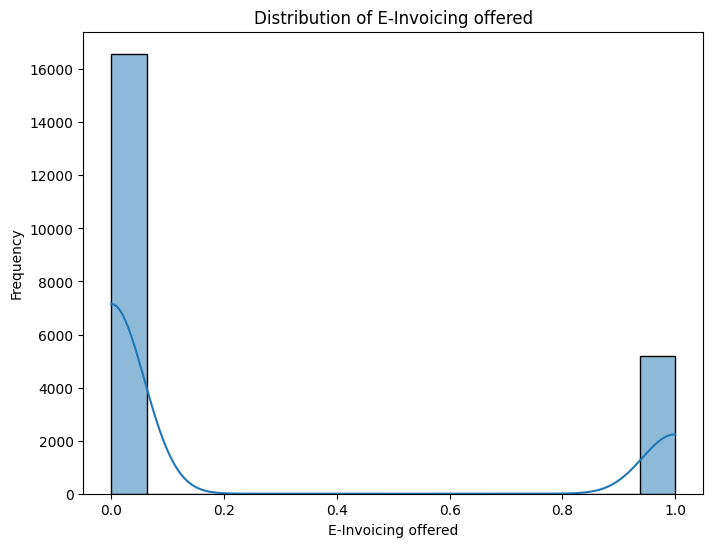

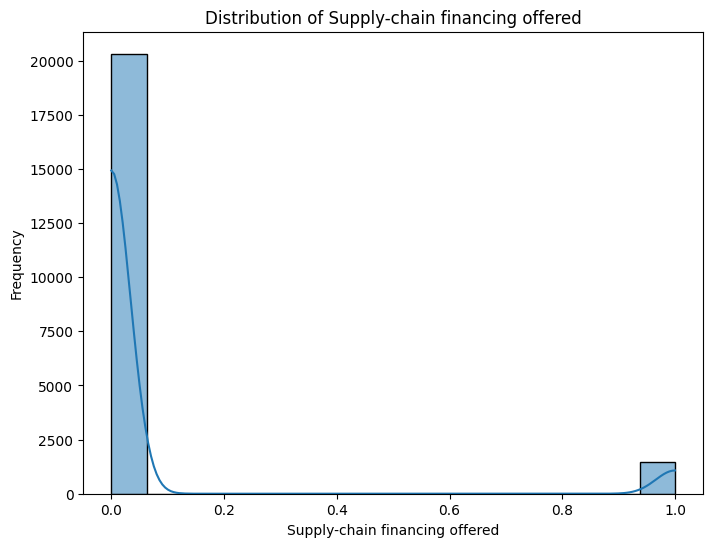

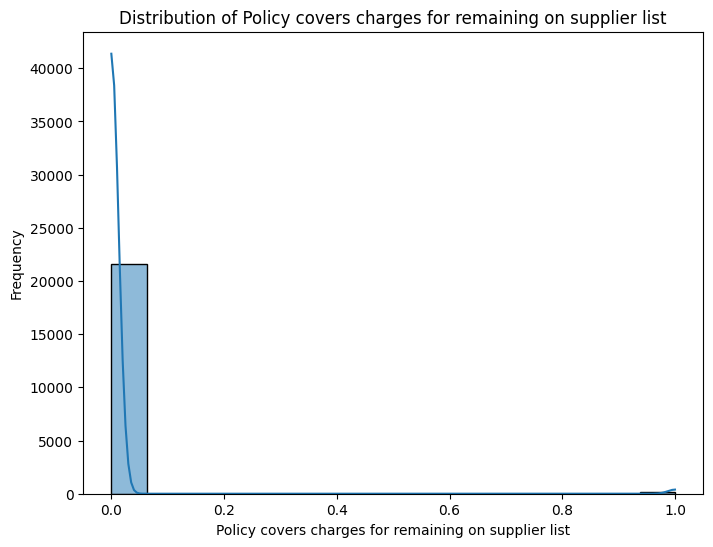

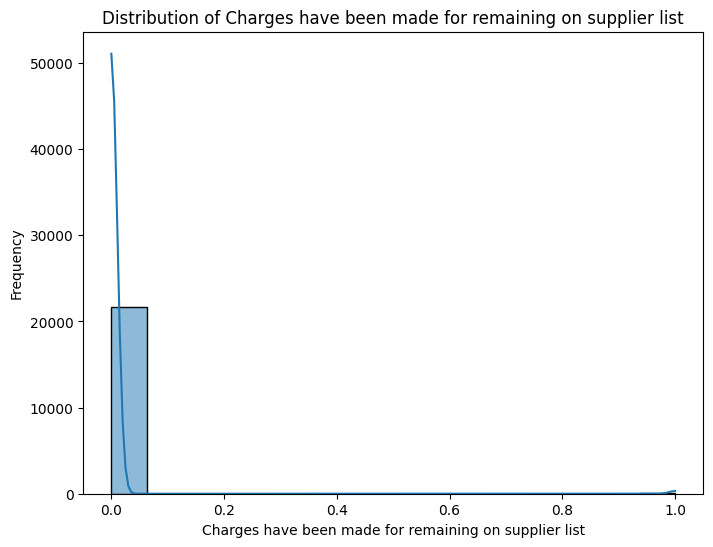

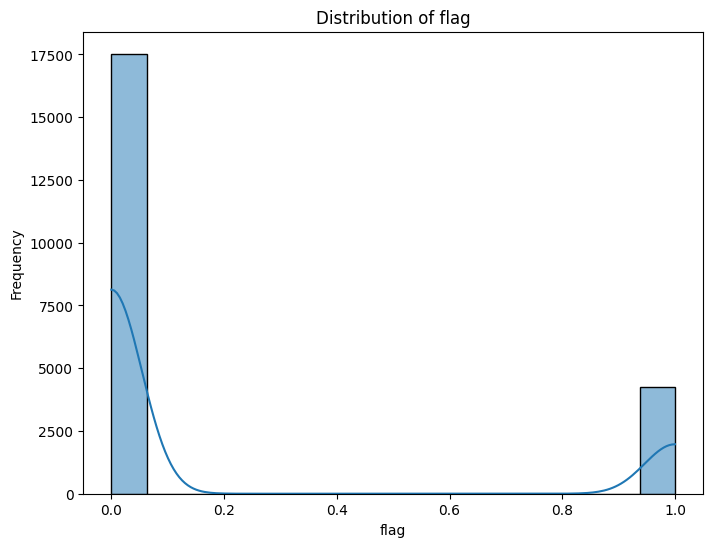

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()




In [38]:
data.columns

Index(['Payments made in the reporting period', 'Average time to pay',
       '% Invoices paid within 30 days',
       '% Invoices paid between 31 and 60 days',
       '% Invoices paid later than 60 days',
       'Shortest (or only) standard payment period',
       'Longest standard payment period', 'Maximum contractual payment period',
       'Payment terms have changed', 'Suppliers notified of changes',
       'Participates in payment codes', 'E-Invoicing offered',
       'Supply-chain financing offered',
       'Policy covers charges for remaining on supplier list',
       'Charges have been made for remaining on supplier list', 'flag'],
      dtype='object')

In [46]:
def calculate_iv(df, feature, target):
    df = df[[feature, target]]
    df = df.dropna()
    n = df.shape[0]
    good = df[target].sum()
    bad = n - good
    unique_values = df[feature].unique()
    iv = 0
    for value in unique_values:
        n1 = df[df[feature] == value].shape[0]
        good1 = df[(df[feature] == value) & (df[target] == 1)].shape[0]
        bad1 = n1 - good1
        if good1 == 0 or bad1 == 0:
            continue
        woe = np.log((good1 / good) / (bad1 / bad))
        iv += (good1 / good - bad1 / bad) * woe
    return iv

Text(0.5, 1.0, 'Information Value of Features')

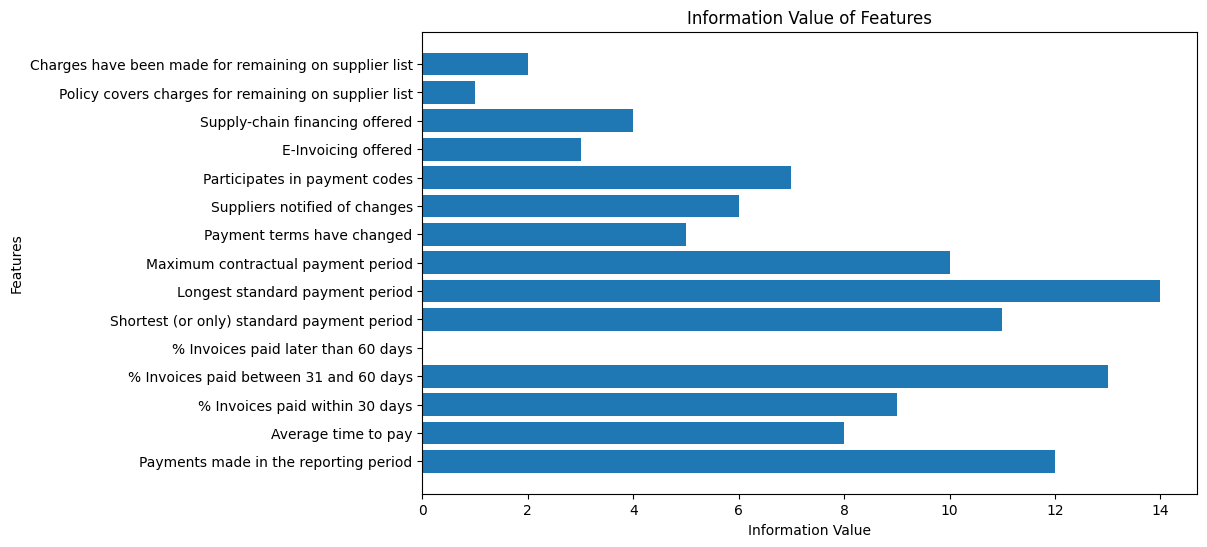

In [54]:
dic = {}
for i in data.drop(columns='flag').columns:
    dic[i] = calculate_iv(data,i,'flag')

IV = pd.DataFrame(dic, index=[0])
IV = np.argsort(IV.values)
plt.figure(figsize=(10, 6))
plt.barh(data.drop(columns='flag').columns[IV.flatten()], IV.flatten())
plt.yticks(range(len(data.drop(columns='flag').columns)), data.drop(columns='flag').columns)
plt.xlabel('Information Value')
plt.ylabel('Features')
plt.title('Information Value of Features')
